In [41]:
import matplotlib.pyplot as plt
import numpy as np
from iminuit import Minuit

fixed_enum = [1, 2, 3]  # no of balls and tries
fixed_keys = ['11', '12', '13', '21', '22', '23', '31', '32', '33'] # the key 'ij' (string) will correspond to the i-th ball and j-th try

def data_extractor(flipped=False):
    '''Extracts data from folder 'ball_data' and converts it into dictionaries
    Returns the 'times' and 'voltages' dictionaries
    When argument 'flipped' is set to True it extracts from files with 'flipped' in their names'''
    raw_data = {}
    for i in fixed_enum:
        for j in fixed_enum:
            if not flipped:
                filename = f'ball{i}_try{j}.csv'
            else:
                filename = f'ball{i}_try{j}_flipped.csv'
            with open(f'ball_data/{filename}', 'r') as file:
                raw_data[f'{i}{j}'] = file.readlines()[15:]    
                

    times = {}
    voltages = {}

    for key, value in raw_data.items():
        times[key] = np.array([float(line.split(',')[0].strip()) for line in value])
        voltages[key] = np.array([float(line.split(',')[1].strip()) for line in value])
    return times, voltages

times, voltages = data_extractor()
times_f, voltages_f = data_extractor(True)



In [ ]:
def left_edges_extractor(times, voltages):
    '''
    Extracts the left edges of the peaks in voltages. Returns dictionaries with edge times and corresponding voltages
    '''
    edge_times = {}
    edge_volts = {}
    # Loop over keys: {'11', '12', ..., '33'}
    for key in fixed_keys:
        times_buff = []
        volts_buff = []
        v_prev = 0
        for t, volt in zip(times[key], voltages[key]):
            if np.abs(volt - 4.78) < 0.1 and np.abs(volt - v_prev) > 0.1:
                times_buff.append(t)
                volts_buff.append(volt)
            v_prev = volt
        # making sure that some extra edge didn't leak
        if len(times_buff) != 5:
            to_delete = []
            for i in range(len(times_buff) - 1):
                if (times_buff[i + 1] - times_buff[i]) < 0.05:
                    to_delete.append(i + 1)
            for ind in to_delete:
                del times_buff[ind]
                del volts_buff[ind]
        edge_times[key] = times_buff
        edge_volts[key] = volts_buff

    return edge_times, edge_volts

edge_times, edge_volts = left_edges_extractor(times, voltages)
edge_times_f, edge_volts_f = left_edges_extractor(times_f, voltages_f)

def shift_to_zero(times, edge_times):
    for key in fixed_keys:
        first_value = edge_times[key][0]
        times[key] += - first_value         # Shifting everything by the first value of the peak
        edge_times[key] += - first_value

print(edge_times['11'])
print(times['11'])
shift_to_zero(times, edge_times)
shift_to_zero(times_f, edge_times_f)
print(edge_times['11'])
print(times['11'])




[np.float64(0.78), np.float64(1.0272), np.float64(1.2004), np.float64(1.3344), np.float64(1.4582)]
[-0.5    -0.4998 -0.4996 ...  3.6974  3.6976  3.6978]
[0.     0.2472 0.4204 0.5544 0.6782]
[-1.28   -1.2798 -1.2796 ...  2.9174  2.9176  2.9178]


In [43]:
def volts_vs_time_plot(ball_no, times, voltages, edge_times, name, interval=(-0.05, 0.7)):
    a, b = interval

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(name)

    axs[0].plot(times[f'{ball_no}1'], voltages[f'{ball_no}1'])
    axs[0].set_title(f"Ball {ball_no}, try 1")

    for t in edge_times[f'{ball_no}1']:
        axs[0].axvline(x=t, color='red', linestyle='--')
    axs[0].set_xticks(ticks=edge_times[f'{ball_no}1'])

    axs[1].plot(times[f'{ball_no}2'], voltages[f'{ball_no}2'])
    axs[1].set_title(f"Ball {ball_no}, try 2")

    for t in edge_times[f'{ball_no}2']:
        axs[1].axvline(x=t, color='red', linestyle='--')
    axs[1].set_xticks(ticks=edge_times[f'{ball_no}2'])

    axs[2].plot(times[f'{ball_no}3'], voltages[f'{ball_no}3'])
    axs[2].set_title(f'Ball {ball_no}, try 3')
    for t in edge_times[f'{ball_no}3']:
        axs[2].axvline(x=t, color='red', linestyle='--')
    axs[2].set_xticks(ticks=edge_times[f'{ball_no}3'])
    # Limits for x
    axs[0].set_xlim(a, b)
    axs[1].set_xlim(a, b)
    axs[2].set_xlim(a, b)

    for ax in axs:
        ax.grid(True)

    plt.tight_layout()
    plt.show()


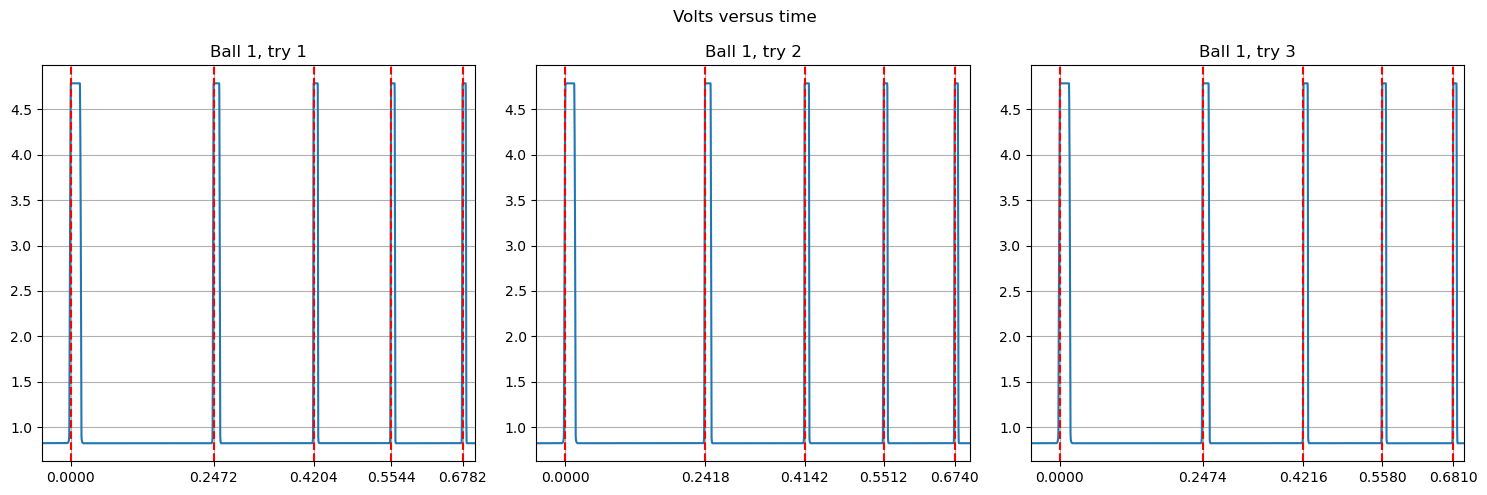

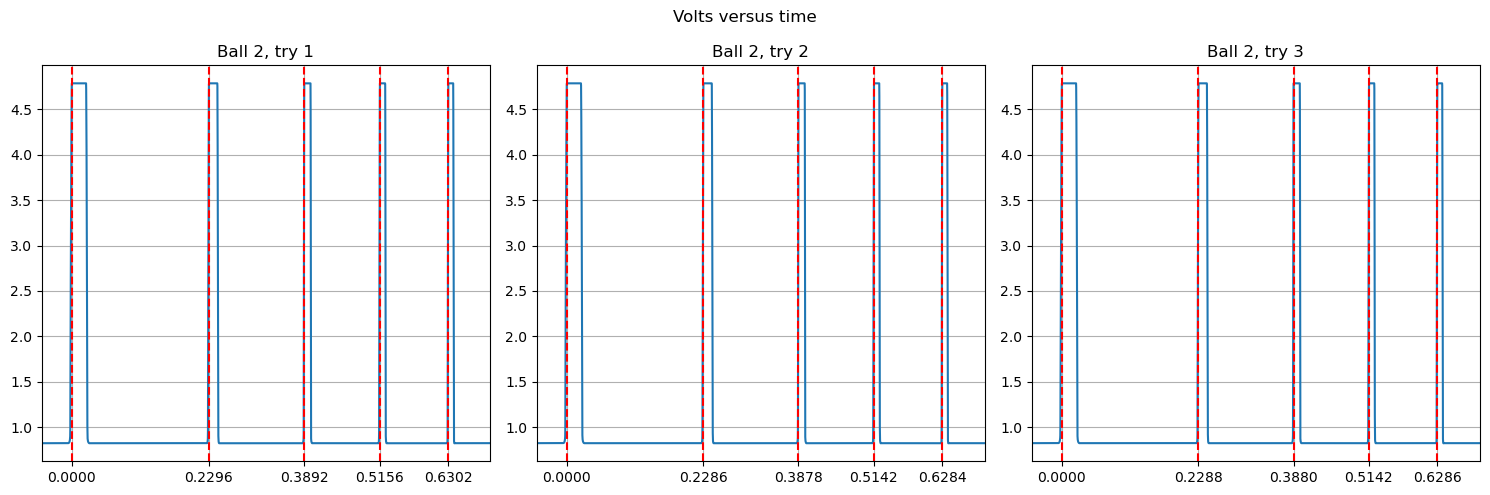

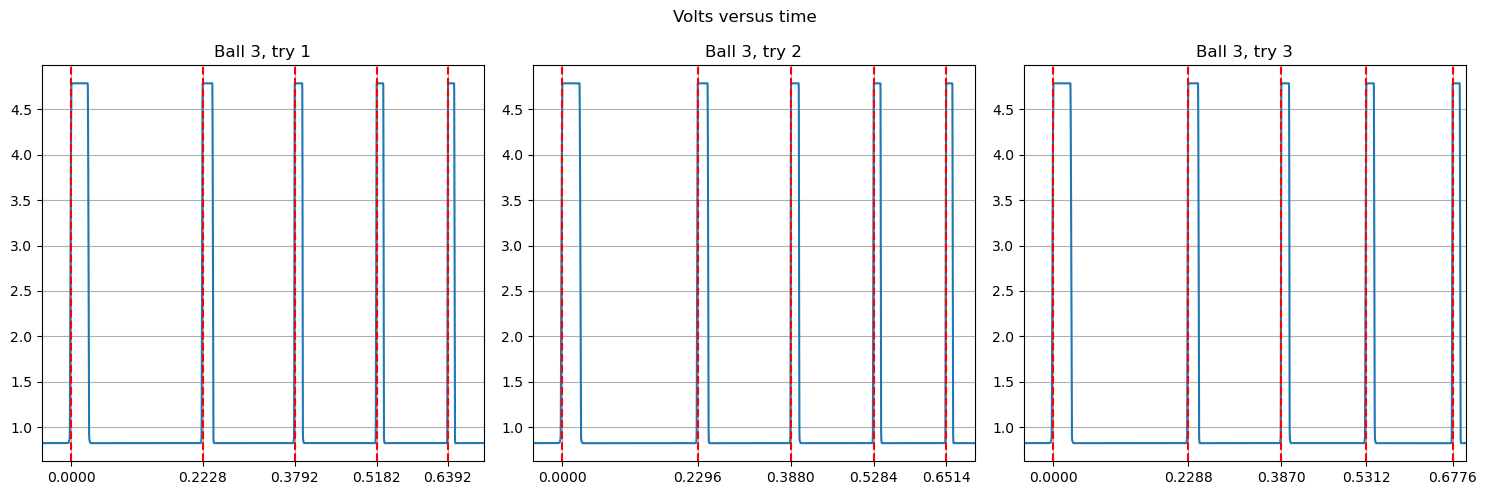

In [44]:

for ball in fixed_enum:
    volts_vs_time_plot(ball, times, voltages, edge_times, 'Volts versus time')



In [45]:
def mean_of_edge(edge_times):
    edge_times_mean = {}
    # calculating the means of the edge_times for each ball
    for i in fixed_enum:
        edge_times_mean[i] = (edge_times[f'{i}1'] + edge_times[f'{i}2'] + edge_times[f'{i}3'])/3
    return edge_times_mean

edge_times_mean = mean_of_edge(edge_times)
edge_times_mean_f = mean_of_edge(edge_times_f)

### Gate positions data treatment
Need to be done only once :)

In [46]:
# Performing fit of a constant function using chi2 method
def constant_fit(data, error):
    value = sum(data/error**2)*1/sum(1/error**2)
    val_error = 1/sum(1/error**2)
    return value, val_error


# Gate positions measurements
x_miguel = np.array([81.5, 65.33, 50.45, 35.25, 20.3])/100
x_michal = np.array([80.8, 65.15, 50.35, 35.05, 20.15])/100
x_sara = np.array([80.95, 65.15, 50.30, 35.05, 20.15])/100
error = 0.05/100

# Inverting the data (first gate reached had the lowest position value)
x_miguel = x_miguel[::-1] - x_miguel[-1]
x_michal = x_michal[::-1] - x_michal[-1]
x_sara = x_sara[::-1] - x_sara[-1]

# making a 3x5 array out of the data
x_blocked = np.block([[x_miguel], [x_michal], [x_sara]])


x_mean = []
x_errors = []

# calculating the mean (using chi2 constant fit although regular mean would work cause all uncertainties are the same)
for col in x_blocked.T:
    val, err = constant_fit(col, error*np.ones_like(col))
    x_mean.append(val)
    x_errors.append(err)
# array with mean positions
x_mean = np.array(x_mean)
# array with uncertainties of the mean positions
x_errors = np.array(x_errors)


### Fiting the data to calculate acceleration

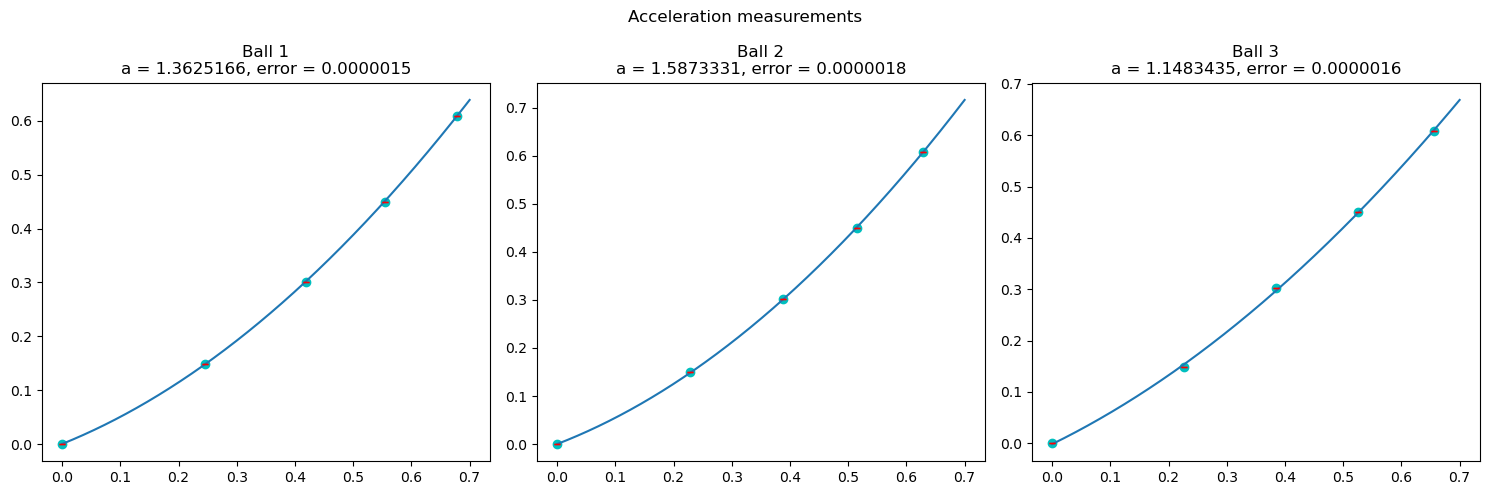

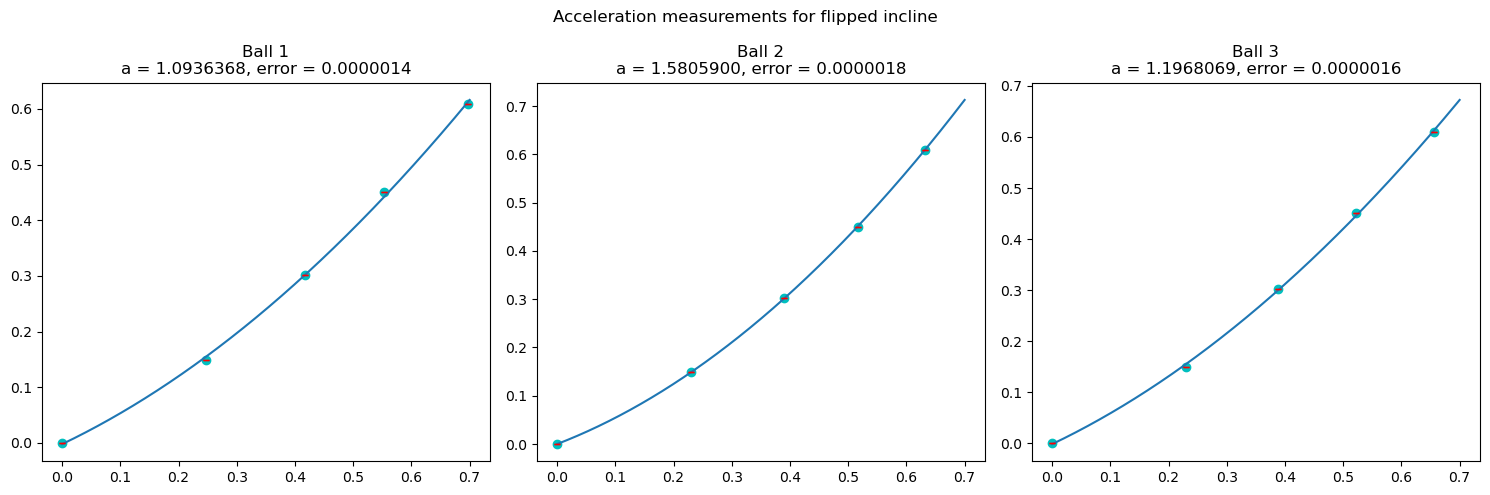

In [47]:
def quadratic_function(t, a, b, c):
    return 0.5*a*t**2+b*t+c

def quadratic_chi2(times, positions, error):
    """
    Returns chi2 to minimize that is only dependent on the fit parameters
    """
    def chi2_parameters(a, b, c):
        chi2_val = sum((positions - quadratic_function(times, a, b, c))**2/error**2)
        return chi2_val
    return chi2_parameters

def quadratic_fit_minimizator(times, positions, error):
    '''
    Minimizes the quadratic chi2
    '''
    m = Minuit(quadratic_chi2(times, positions, error), a=0.1, b=0, c=0)
    m.migrad();
    # print(m.values[0:])
    # print(m.errors[0:])
    return m.values[0:], m.errors[0:]
# Extracting fit parameters

def position_vs_time_with_fit(edge_times_mean, x_mean, x_errors, precision=7, flipped=False):


    pars1, errs1 = quadratic_fit_minimizator(edge_times_mean[1], x_mean, x_errors)
    pars2, errs2 = quadratic_fit_minimizator(edge_times_mean[2], x_mean, x_errors)
    pars3, errs3 = quadratic_fit_minimizator(edge_times_mean[3], x_mean, x_errors)


    domain = np.linspace(0, 0.7, 1000)
    vals1 = quadratic_function(domain, pars1[0], pars1[1], pars1[2])
    vals2 = quadratic_function(domain, pars2[0], pars2[1], pars2[2])
    vals3 = quadratic_function(domain, pars3[0], pars3[1], pars3[2])


    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    if flipped:
        fig.suptitle('Acceleration measurements for flipped incline')
    else:
        fig.suptitle('Acceleration measurements')
    axs[0].plot(domain, vals1)
    axs[0].scatter(edge_times_mean[1], x_mean, color='c')
    axs[0].errorbar(edge_times_mean[1], x_mean, yerr=x_errors, fmt='none', ecolor='red', capsize=2)
    axs[0].set_title(f'Ball 1\na = {pars1[0]:.{precision}f}, error = {errs1[0]:.{precision}f}')


    axs[1].plot(domain, vals2)
    axs[1].scatter(edge_times_mean[2], x_mean, color='c')
    axs[1].errorbar(edge_times_mean[2], x_mean, yerr=x_errors, fmt='none', ecolor='red', capsize=2)
    axs[1].set_title(f'Ball 2\na = {pars2[0]:.{precision}f}, error = {errs2[0]:.{precision}f}')

    axs[2].plot(domain, vals3)
    axs[2].scatter(edge_times_mean[3], x_mean, color='c')
    axs[2].errorbar(edge_times_mean[3], x_mean, yerr=x_errors, fmt='none', ecolor='red', capsize=2)
    axs[2].set_title(f'Ball 3\na = {pars3[0]:.{precision}f}, error = {errs3[0]:.{precision}f}')

    plt.tight_layout()
    plt.show()


position_vs_time_with_fit(edge_times_mean, x_mean, x_errors)
position_vs_time_with_fit(edge_times_mean_f, x_mean, x_errors, flipped=True)


In [48]:
def acceleration_computoinator(edge_times_mean, x_mean, x_errors):
    pars1, errs1 = quadratic_fit_minimizator(edge_times_mean[1], x_mean, x_errors)
    pars2, errs2 = quadratic_fit_minimizator(edge_times_mean[2], x_mean, x_errors)
    pars3, errs3 = quadratic_fit_minimizator(edge_times_mean[3], x_mean, x_errors)
    a1 = pars1[0]
    u_a1 = errs1[0]
    
    a2 = pars2[0]
    u_a2 = errs2[0]
    
    a3 = pars3[0]
    u_a3 = errs3[0]

    return a1, u_a1, a2, u_a2, a3, u_a3


a1, u_a1, a2, u_a2, a3, u_a3 = acceleration_computoinator(edge_times_mean, x_mean, x_errors)
a1_f, u_a1_f, a2_f, u_a2_f, a3_f, u_a3_f = acceleration_computoinator(edge_times_mean_f, x_mean, x_errors)



### Angle data treatment
To do - what is the mean angle and its error that should be put to formula? - for now I just put the goniometer angle (I think it is the best)



In [49]:
# Angles using trigonometry

def alpha(opposite, adjacent):
    return np.arctan(opposite/adjacent)

def error_alpha(opposite, adjacent, ruler_error=0.05):
    return ruler_error/np.sqrt(opposite**2 + adjacent**2)

op_miguel = 22.2
op_michal = 21.8
op_sara = 22.15

adj_miguel = 89.75
adj_michal = 89.1
adj_sara = 89.75

alpha_miguel = alpha(op_miguel, adj_miguel)
error_alpha_miguel = error_alpha(op_miguel, adj_miguel)

alpha_michal = alpha(op_michal, adj_michal)
error_alpha_michal = error_alpha(op_michal, adj_michal)

alpha_sara = alpha(op_sara, adj_sara)
error_alpha_sara = error_alpha(op_sara, adj_sara)

print(f'Miguel: alpha = {alpha_miguel:.5f}, error = {error_alpha_miguel:.5f}\nMichal: alpha = {alpha_michal:.5f}, error = {error_alpha_michal:.5f}\nSara: alpha = {alpha_sara:.5f}, error = {error_alpha_sara:.5f}')

# Goniometer measurements 

angle_gonio1 = 13.9*np.pi/180 # og orientation
angle_gonio2 = 14.0*np.pi/180  # flipped
error_gonio = 0.07*np.pi/180  # something like that???
# The table deviation from horizontalness
angle_table = 0.1*np.pi/180




Miguel: alpha = 0.24249, error = 0.00054
Michal: alpha = 0.23995, error = 0.00055
Sara: alpha = 0.24196, error = 0.00054


### Ball size and rail width data

In [50]:
D1 = 10.0/1000
D2 = 15/1000
D3 = 19/1000
u_D = 0.1/1000

d = 6/1000
u_d = 0.5/1000

### Finally - calculating the g and its error based upon the overall data
I still don't know what the delta theta is, so I put 0 for now

In [51]:
def g_incline(a, theta, deltheta, D, d):
    return a/np.sin(theta + deltheta)*(1 + 2/5*D**2/(D**2 - d**2))

def g_error(a, u_a, theta, u_theta, deltheta, u_deltheta, D, u_D, d, u_d):
    '''To check for mistakes - calculating this by hand was a pain in the ass'''
    var = (1 + 2/5*D**2/(D**2 - d**2))**2/np.sin(theta + deltheta)**2*(u_a**2 + (u_theta**2 + u_deltheta**2)*a**2/np.tan(theta + deltheta)**2) + 16/25*a**2/np.sin(theta + deltheta)**2*D**2*d**2/(D**2 - d**2)**4*(d**2*u_D**2 + D**2*u_d**2)
    return np.sqrt(var)

g1 = g_incline(a1, angle_gonio1, 0, D1, d)
u_g1 = g_error(a1, u_a1, angle_gonio1, error_gonio, 0, 0, D1, u_D, d, u_d)

g2 = g_incline(a2, angle_gonio1, 0, D2, d)
u_g2 = g_error(a2, u_a2, angle_gonio1, error_gonio, 0, 0, D2, u_D, d, u_d)

g3 = g_incline(a3, angle_gonio1, 0, D3, d)
u_g3 = g_error(a3, u_a3, angle_gonio1, error_gonio, 0, 0, D3, u_D, d, u_d)

g1_f = g_incline(a1_f, angle_gonio1, 0, D1, d)
u_g1_f = g_error(a1_f, u_a1_f, angle_gonio1, error_gonio, 0, 0, D1, u_D, d, u_d)

g2_f = g_incline(a2_f, angle_gonio1, 0, D2, d)
u_g2_f = g_error(a2_f, u_a2_f, angle_gonio1, error_gonio, 0, 0, D2, u_D, d, u_d)

g3_f = g_incline(a3_f, angle_gonio1, 0, D3, d)
u_g3_f = g_error(a3_f, u_a3_f, angle_gonio1, error_gonio, 0, 0, D3, u_D, d, u_d)

print('For og orientation:')
print(f'Ball 1: g = {g1:.2f}, error = {u_g1:.2f}\nBall 2: g = {g2:.2f}, error = {u_g2:.2f}\nBall 3: g = {g3:.3f}, error = {u_g3:.3f}')
print('\nFor flipped incline:')
print(f'Ball 1: g = {g1_f:.2f}, error = {u_g1_f:.2f}\nBall 2: g = {g2_f:.2f}, error = {u_g2_f:.2f}\nBall 3: g = {g3_f:.3f}, error = {u_g3_f:.3f}')





For og orientation:
Ball 1: g = 9.22, error = 0.34
Ball 2: g = 9.75, error = 0.11
Ball 3: g = 6.904, error = 0.052

For flipped incline:
Ball 1: g = 7.40, error = 0.27
Ball 2: g = 9.71, error = 0.11
Ball 3: g = 7.195, error = 0.054


{'11': array([-0.5   , -0.4998, -0.4996, ...,  3.6974,  3.6976,  3.6978]), '12': array([-0.5   , -0.4998, -0.4996, ...,  4.4994,  4.4996,  4.4998]), '13': array([-0.5   , -0.4998, -0.4996, ...,  3.4118,  3.412 ,  3.4122]), '21': array([-0.5   , -0.4998, -0.4996, ...,  2.688 ,  2.6882,  2.6884]), '22': array([-0.5   , -0.4998, -0.4996, ...,  2.4466,  2.4468,  2.447 ]), '23': array([-0.5   , -0.4998, -0.4996, ...,  1.2434,  1.2436,  1.2438]), '31': array([-0.5   , -0.4998, -0.4996, ...,  1.4788,  1.479 ,  1.4792]), '32': array([-0.5   , -0.4998, -0.4996, ...,  1.9038,  1.904 ,  1.9042]), '33': array([-0.5   , -0.4998, -0.4996, ...,  1.0496,  1.0498,  1.05  ])}
{'11': array([-0.5   , -0.4998, -0.4996, ...,  3.6974,  3.6976,  3.6978]), '12': array([-0.5   , -0.4998, -0.4996, ...,  4.4994,  4.4996,  4.4998]), '13': array([-0.5   , -0.4998, -0.4996, ...,  3.4118,  3.412 ,  3.4122]), '21': array([-0.5   , -0.4998, -0.4996, ...,  2.688 ,  2.6882,  2.6884]), '22': array([-0.5   , -0.4998, -0.49

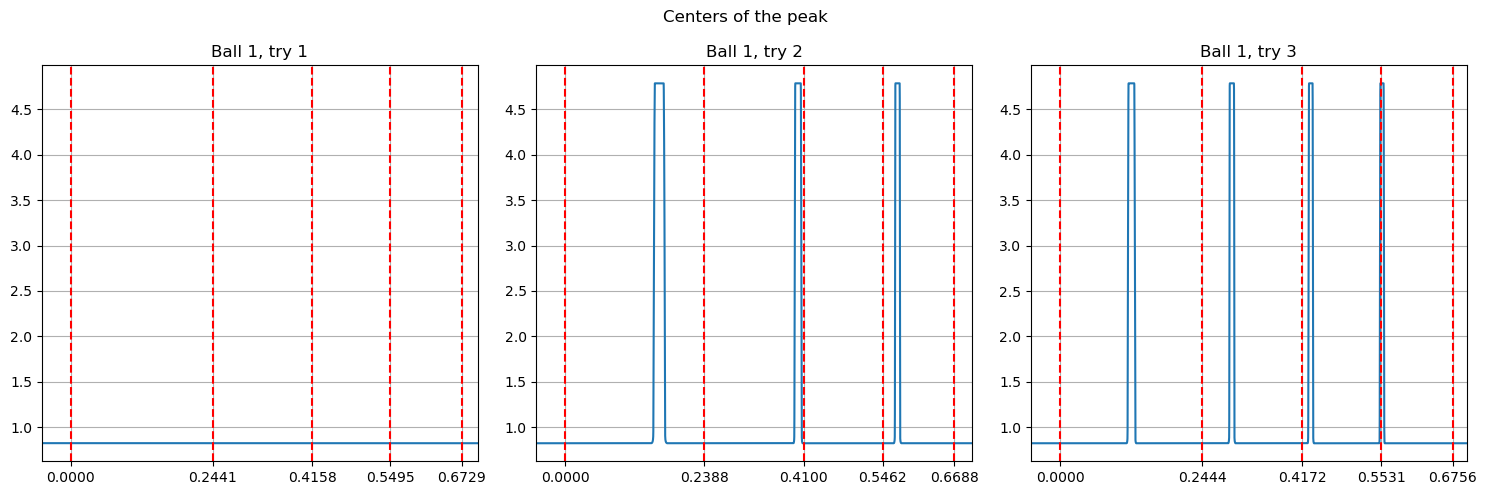

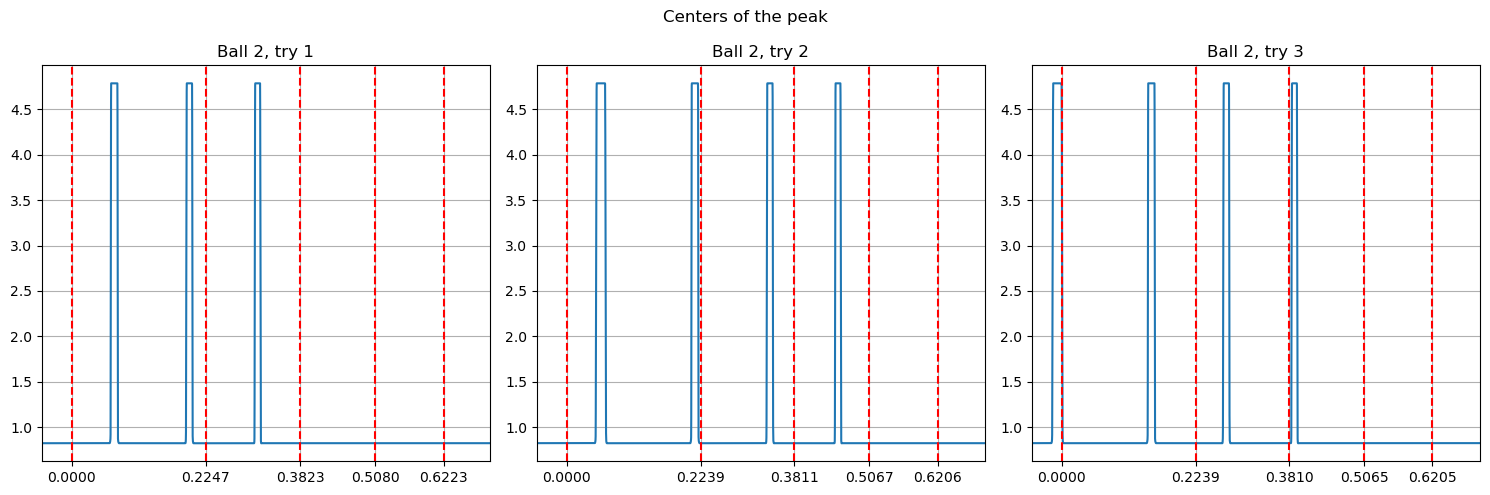

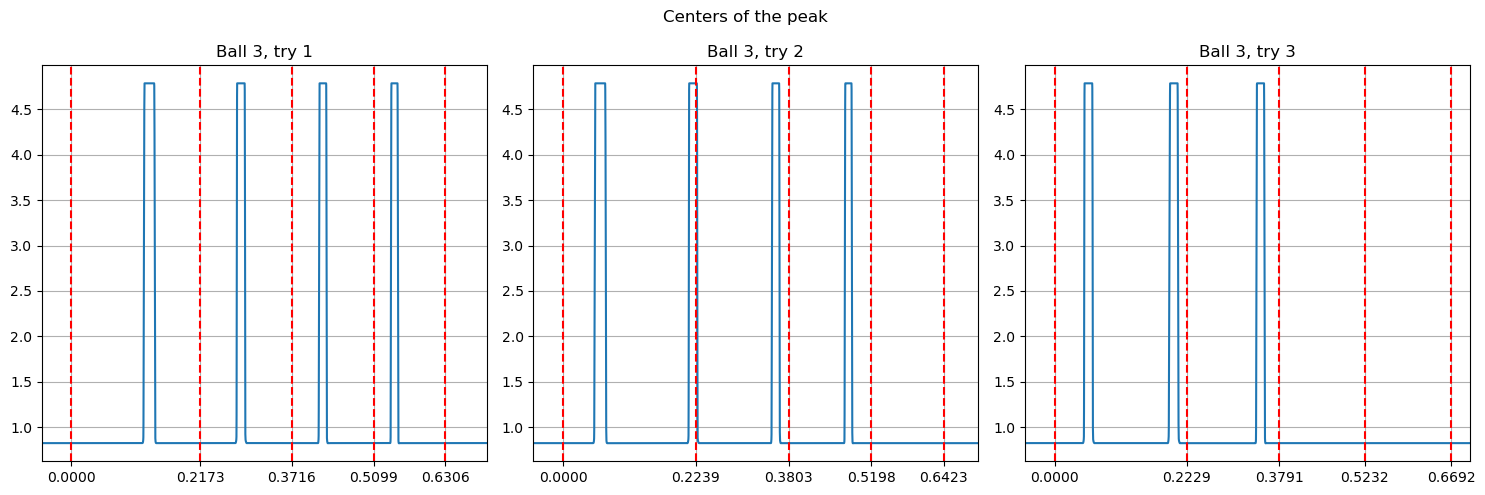

In [ ]:
from BallOnIncline import combined
#print(combined)

midpoints = {}
for key, row in zip(fixed_keys, combined):
    midpoints[key] = row

times_m, voltages_m = data_extractor()

print(times_m)
print(midpoints)
shift_to_zero(times_m, midpoints)
print(times_m)


volts_vs_time_plot(1, times_m, voltages_m, midpoints, 'Centers of the peak')
volts_vs_time_plot(2, times_m, voltages_m, midpoints, 'Centers of the peak')
volts_vs_time_plot(3, times_m, voltages_m, midpoints, 'Centers of the peak')



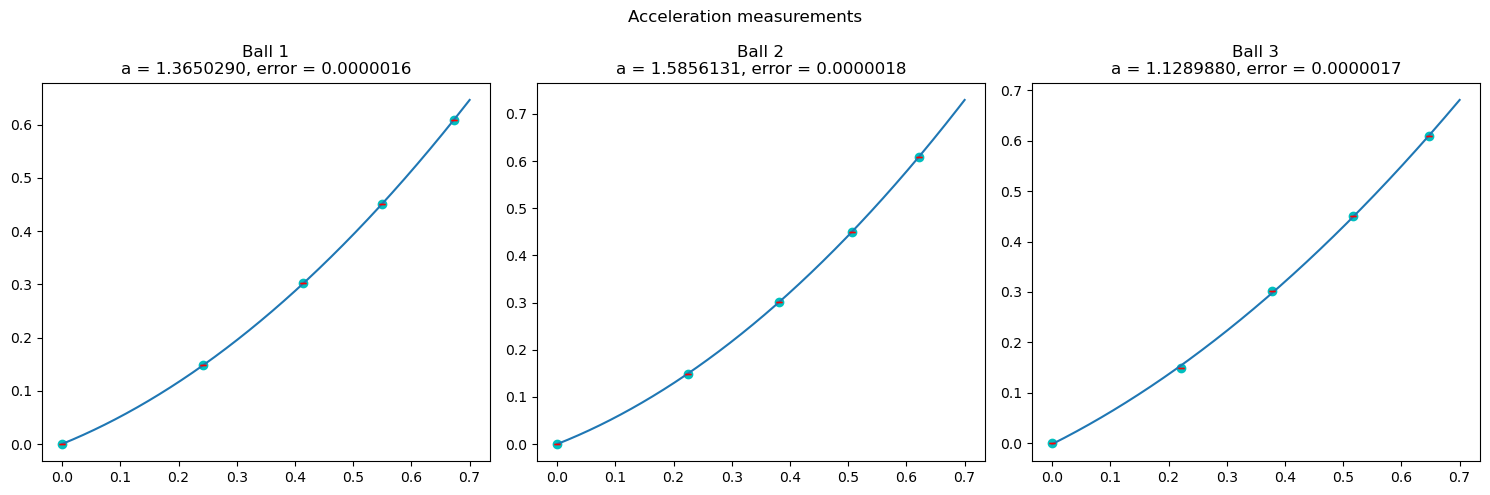

In [53]:

midpoints_mean = mean_of_edge(midpoints)


position_vs_time_with_fit(midpoints_mean, x_mean, x_errors)


In [ ]:
a1_m, u_a1_m, a2_m, u_a2_m, a3_m, u_a3_m = acceleration_computoinator(midpoints_mean, x_mean, x_errors)

g1_m = g_incline(a1_m, angle_gonio1, 0, D1, d)
u_g1_m = g_error(a1_m, u_a1_m, angle_gonio1, error_gonio, 0, 0, D1, u_D, d, u_d)

g2_m = g_incline(a2_m, angle_gonio1, 0, D2, d)
u_g2_m = g_error(a2_m, u_a2_m, angle_gonio1, error_gonio, 0, 0, D2, u_D, d, u_d)

g3_m = g_incline(a3_m, angle_gonio1, 0, D3, d)
u_g3_m = g_error(a3_m, u_a3_m, angle_gonio1, error_gonio, 0, 0, D3, u_D, d, u_d)

print('\nFor flipped incline:')
print(f'Ball 1: g = {g1_m:.2f}, error = {u_g1_m:.2f}\nBall 2: g = {g2_m:.2f}, error = {u_g2_m:.2f}\nBall 3: g = {g3_m:.3f}, error = {u_g3_m:.3f}')





For flipped incline:
Ball 1: g = 9.23, error = 0.34
Ball 2: g = 9.74, error = 0.11
Ball 3: g = 6.788, error = 0.051
